In [1]:
%run classes.ipynb
# Training cell
import numpy as np
from sklearn.model_selection import train_test_split

emptyRatioA = 47
emptyRatioB = 30
objectwidth = 83
objectheight = 122

odtype = 'scatter'
neighbourhoodDistance = 3
porositythreshold = 0.5
neighbourhoodZ = 1
windowSize = 10
windowOffset = 5
noOfBins = 20
n_neighbors = 3
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))

X_train = readRawTreeImages()
labels = getLabels(porositythreshold)
Y_train = np.copy(labels)

X_test = readRawHouseImages()

# Todo: Uncomment this line

mask = makeMask(Y_train, emptyRatioA)

bgr = backgroundRemover(mask)
ab = blockAccumulator(windowSize, windowOffset)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ)
# a1 = accumulator(windowSize, windowOffset)

# Hur modellerar vi det här? Objekt med olika höjd blir kaos, eller? Skulle kunna skicka tomma bilder när de är slut. 

allTrainingHists = []

def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects = np.moveaxis(X_train, 1, 0)
testObjects = np.moveaxis(X_test, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    i +=1 
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)
    # if(i == 0 or i == 1 or i == 2):
    #     plt.imshow(pres[0])
    #     plt.figure()
    #     plt.hist(pres[0].flatten())
    #     plt.yscale('log')
    #     plt.figure()
    # ocVals: List[layers][objects][matrix]
ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        # tar encode en lista av 3d?
        hists = e1.encode(ocvals)
        for acc in hists:
            allTrainingHists.append(acc)

repetitions = len(allTrainingHists) / len(Y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(Y_train.astype('int'), [np.int32(repetitions)])
clf.fit(allTrainingHists, ytrain2)

0.9822596317987237


Text(0.5, 0, 'Timestep')

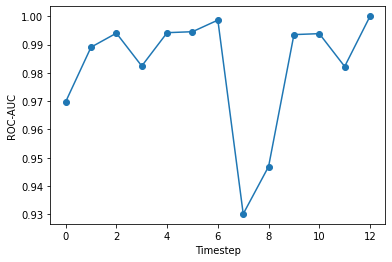

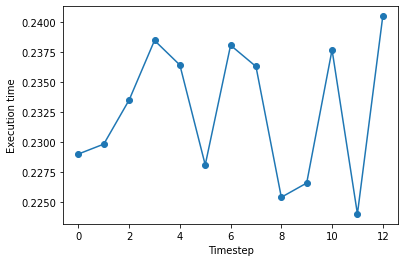

In [57]:
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
import time
oc1.reset()
y_test = Y_test.astype('int')

testx = []
predictions = []
letsPrint = False
times = []
for image in testObjects:
    # Start of timing
    start_time = time.time()
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    hists = e1.encode(ocvals)
    pred = clf.predict_proba(hists)[:,1]
    times.append(time.time() - start_time)
    # End of timing
    testx.append(hists)
    predictions.append(pred)
    if len(ocvals) > 0:
        if(letsPrint):
            plt.imshow(image[0])
            plt.title("background 0")
            plt.figure()
            plt.imshow(image[1])
            plt.title("background 1")
            plt.figure()
            plt.imshow(noback[0])
            plt.title("nobackground 0")
            plt.figure()
            plt.imshow(noback[1])
            plt.title("nobackground 1")
            plt.figure()
            plt.imshow(pres[0])
            plt.title("pres 0")
            plt.figure()
            plt.imshow(pres[1])
            plt.title("pres 1")
            plt.figure()
            plt.imshow(ocvals[0])
            plt.title("ocvals 0")
            plt.figure()
            plt.imshow(ocvals[1])
            plt.title("ocvals 1")
            plt.figure()
            plt.hist(ocvals[0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            plt.hist(ocvals[1].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            break

# investigate accuracy etc here. Potentially batch it based on layer
ysvalue = []
for index, o in enumerate(predictions):
    ysvalue.append(roc_auc_score(y_test, o))
plt.plot(np.arange(0, len(ysvalue)), ysvalue, 'o-')
print(np.mean(ysvalue))
plt.ylabel("ROC-AUC")
plt.xlabel("Timestep")
plt.figure()
plt.plot(np.arange(0, len(times)), times, 'o-')
plt.ylabel("Execution time")
plt.xlabel("Timestep")